In [1]:
# Import dependencies.
from __future__ import division
import pandas as pd
from os import getcwd, listdir, path
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import findspark
findspark.init()
import pyspark
import time
from IPython.display import Image
from IPython.display import HTML
from IPython.display import display
from PIL import Image
import urllib
import requests
import json

In [2]:
# Input all the data and combine them into one dataframe.
ratings = pd.read_csv(getcwd()+"/ml-latest/ratings.csv")
movies = pd.read_csv(getcwd()+"/ml-latest/movies.csv")
links = pd.read_csv(getcwd()+"/ml-latest/links.csv")
result = ratings.merge(movies, on = "movieId")
result = result.merge(links, on = "movieId")
reviews_df = result.sort_values(by = "userId").reset_index(drop = True)

<font size="7", face="arial"><i><strong>Exploratory Data Analysis</strong></i></font>

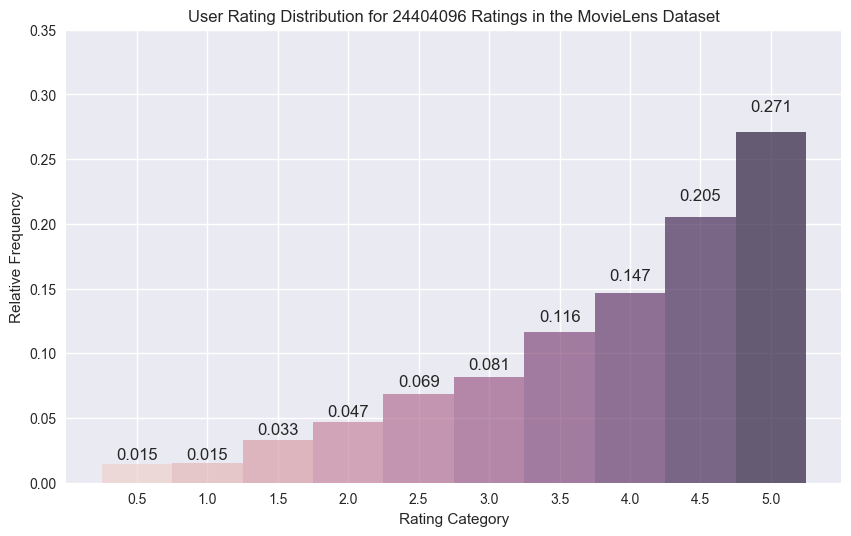

In [3]:
# Plot the user rating distribution.

N_star_categories = 10
star_labels = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
star_category_dist_fig = plt.figure(figsize = (10, 6), dpi = 100)
bar_plot_indices = np.arange(N_star_categories)
star_category_absolute_frequencies = reviews_df.rating.value_counts(ascending = True)
star_category_relative_frequencies = (np.array(star_category_absolute_frequencies)/
                                      float(sum(star_category_absolute_frequencies)))
rects = (plt.bar(bar_plot_indices, star_category_relative_frequencies, width = 1, 
                 color = sns.cubehelix_palette(10), alpha = .7))

for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x() + rect.get_width()/2., 1.05*rect.get_height(), 
                       '%.3f'%(star_category_relative_frequencies[idx]), ha = 'center', va = 'bottom')

plt.xticks(bar_plot_indices, np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]))
plt.xlabel('Rating Category')
plt.ylabel('Relative Frequency')
plt.ylim([0, 0.35])
plt.title('User Rating Distribution for {} Ratings in the MovieLens Dataset'.format(len(reviews_df)))

plt.show()
# star_category_dist_fig.savefig("user_rating_distribution.png")

<p><font size="4", face="arial">As the rating gets higher, the relative frequency gets higher as well.</font></p>

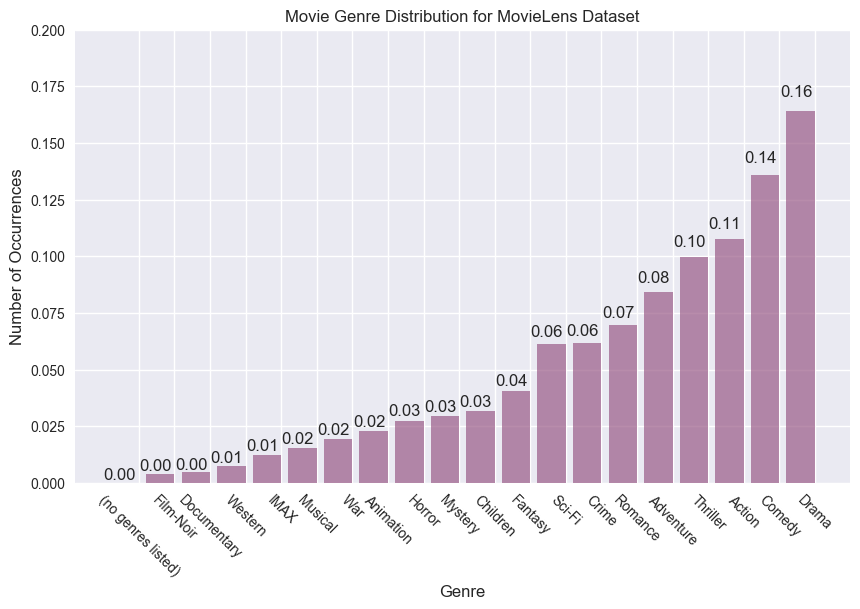

In [4]:
# Plot the genre distribution.

genre_list = [genre.split("|") for genre in reviews_df.genres]
genre_list = [str(element) for sublist in genre_list for element in sublist]

genre_df = pd.DataFrame.from_dict(dict(Counter(genre_list)), orient = "index")
genre_df["genre"] = list(genre_df.index)
genre_df.index = range(len(genre_df))
genre_df.columns = ["count", "genre"]
genre_df = genre_df.sort_values(by = "count", ascending = False).reset_index()

barplot_indices = np.arange(len(genre_df))
relative_genre_freq = [num/sum(genre_df["count"]) for num in list(genre_df["count"])]
genre_dist = plt.figure(figsize = (10, 6), dpi = 100)
rects = (plt.bar(barplot_indices[::-1], relative_genre_freq, 
                     alpha = 0.7, color = sns.cubehelix_palette(8)[4]))
for idx, rect in enumerate(rects):
    plt.gca().text(rect.get_x()+rect.get_width()/3., 1.03*rect.get_height(), 
                   "%.2f"%(relative_genre_freq[idx]), ha = 'center', va = 'bottom')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel("Genre", fontsize = 12)
plt.xticks(barplot_indices+0.4, genre_df.genre[::-1], rotation = -45)
plt.ylim([0, 0.2])
plt.title("Movie Genre Distribution for MovieLens Dataset")
plt.show()
# num_of_words_dist.savefig("num_of_words_dist.png")

<font size="7", face="arial"><i><strong>Model</strong></i></font>

<font size="4", face="arial"><p>In this section we adopt <u><strong>collaborative filtering</strong></u> as our movie recommendation model.</p>

<p>Mathematically, we can fill users and movies in a sparse matrix, where each row represents a user and each column represents a movie. A user has different taste for every movie, and this taste can be expressed as a vector where each entry is a number between 0 and 1. 1 means this user absolutely loves this movie and 0 means this user has no interest in this movie whatsoever.</p>

<p>The final outcome of this section is that, when a new user added to the dataset, the recommender will introduce a movie to this user based on similar users' taste.</p>

<p>Optimal parameters for the model:</p>

<ul>
<li>iterations = 10</li>
<li>seed = 5L</li>
<li>regularization_parameter = 0.25</li>
<li>best_rank = 8</li>
</ul>
</font>

In [28]:
sc.stop()
sc = pyspark.SparkContext()

# Import the whole dataset.
full_data = sc.textFile(path.join(getcwd(), "ml-latest", "ratings.csv"))

In [29]:
small_data_header = full_data.take(1)[0]

# Parse the data and read in one line of form (user, movie, rating) each time. 
small_ratings_data = (full_data.filter(lambda line: line != small_data_header)
                      .map(lambda line: line.split(","))
                      .map(lambda tokens: (tokens[0], tokens[1], tokens[2])).cache())

In [18]:
# Split the data into training, validation and testing parts.
training_RDD, validation_RDD, test_RDD = small_ratings_data.randomSplit([6, 2, 2], seed = 0L)

validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [19]:
from pyspark.mllib.recommendation import ALS
import math

start_time = time.time()
print "Start training the data"

seed = 5L
iterations = 10
regularization_parameter = 0.25
ranks = [4, 8, 12, 16]
errors = [0, 0, 0, 0]
err = 0
tolerance = 0.02

min_error = float("inf")
best_rank = -1
best_iteration = -1
for rank in ranks:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations, lambda_=regularization_parameter)
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print "For rank %s the RMSE is %s" % (rank, error)
    if error < min_error:
        min_error = error
        best_rank = rank

print "The best model was trained with rank %s" % best_rank
print "{} seconds elapsed".format(time.time()-start_time)

Start training the data
For rank 4 the RMSE is 0.890888480874
For rank 8 the RMSE is 0.88964535534
For rank 12 the RMSE is 0.8899641212
For rank 16 the RMSE is 0.890008684083
The best model was trained with rank 8
711.61410594 seconds elapsed


In [20]:
print "Start testing the data"
start_time = time.time()

model = ALS.train(training_RDD, best_rank, seed = seed, iterations = iterations, 
                  lambda_ = regularization_parameter)
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print "For testing data the RMSE is %s" % (error)
print "{} seconds elapsed".format(time.time()-start_time)

For testing data the RMSE is 0.889806216555


In [21]:
# 70% training data and 30% testing data.
training_RDD, test_RDD = small_ratings_data.randomSplit([7, 3], seed = 0L)

# Use parameters obtained above to obtain the model for recommendation.
complete_model = ALS.train(training_RDD, best_rank, seed = seed, 
                           iterations = iterations, lambda_ = regularization_parameter)

In [22]:
print "Start testing the data"
start_time = time.time()

test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

predictions = complete_model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print "For testing data the RMSE is %s" % (error)
print "{} seconds elapsed".format(time.time()-start_time)

Start testing the data
For testing data the RMSE is 0.888972126783
143.214412928 seconds elapsed


In [ ]:
small_ratings_data = (full_data.filter(lambda line: line != small_data_header)
                      .map(lambda line: line.split(","))
                      .map(lambda tokens: (tokens[0], tokens[1], tokens[2])).cache())

In [35]:
complete_movies_raw_data = sc.textFile(path.join(getcwd(), "ml-latest", "movies.csv"))
complete_movies_raw_data_header = complete_movies_raw_data.take(1)[0]

# Parse 
complete_movies_data = (complete_movies_raw_data.filter(lambda line: line != complete_movies_raw_data_header)
                        .map(lambda line: line.split(","))
                        .map(lambda tokens: (int(tokens[0]),tokens[1],tokens[2])).cache())

complete_movies_titles = complete_movies_data.map(lambda x: (int(x[0]), x[1]))
    
print "There are {} movies in the complete dataset".format(complete_movies_titles.count())

There are 40110 movies in the complete dataset


In [30]:
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return(ID_and_ratings_tuple[0], (nratings, float(sum(float(x) for x in ID_and_ratings_tuple[1]))/nratings))

movie_ID_with_ratings_RDD = small_ratings_data.map(lambda x: (x[1], x[2])).groupByKey().mapValues(list)
movie_ID_with_avg_ratings_RDD = movie_ID_with_ratings_RDD.map(get_counts_and_averages)
movie_rating_counts_RDD = movie_ID_with_avg_ratings_RDD.map(lambda x: (int(x[0]), x[1][0]))

<p><font size="4", face="arial">Suppose a new user is added to the dataset, and begin to perform the recommendation.</font></p>

In [31]:
new_user_ID = 0

new_user_ratings = [
     (0, 130, 4), # Angela (1995)
     (0, 7584, 3), # Woman of the Year (1942)
     (0, 4248, 2), # Josie and the Pussycats (2001)
     (0, 2169, 1), # Dead Man on Campus (1998)
     (0, 2042, 5), # D2: The Mighty Ducks (1994)
     (0, 335, 1), # Underneath (1995)
     (0, 1791, 1), # Twilight (1998)
     (0, 296, 3), # Pulp Fiction (1994)
     (0, 1350, 5) , # Omen, The (1976)
     (0, 50, 5) # Usual Suspects, The (1995)
]

new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print "New user ratings: %s" % new_user_ratings_RDD.take(10)

New user ratings: [(0, 130, 4), (0, 7584, 3), (0, 4248, 2), (0, 2169, 1), (0, 2042, 5), (0, 335, 1), (0, 1791, 1), (0, 296, 3), (0, 1350, 5), (0, 50, 5)]


In [34]:
# Add this new user to the dataset.
complete_data_with_new_ratings_RDD = small_ratings_data.union(new_user_ratings_RDD)

start_time = time.time()

# Everytime a new user is added to the dataset, the model needs to be trained again.
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed = seed, 
                              iterations = iterations, lambda_ = regularization_parameter)

final_time = time.time()-start_time

print "New model trained in %s seconds" % round(final_time, 3)

New model trained in 73.217 seconds


In [44]:
new_user_ratings_ids = map(lambda x: x[1], new_user_ratings)

new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids)
                               .map(lambda x: (new_user_ID, x[0])))

print "Start prediction"
start_time = time.time()

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() 
# to predict new ratings for the movies that new user has not seen.
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = (new_user_recommendations_rating_RDD
                                                       .join(complete_movies_titles).join(movie_rating_counts_RDD))

new_user_recommendations_rating_title_and_count_RDD = (new_user_recommendations_rating_title_and_count_RDD
                                                       .map(lambda r: (r[1][0][1], r[1][0][0], r[1][1])))

top_movies = (new_user_recommendations_rating_title_and_count_RDD
              .filter(lambda r: r[2] >= 25).takeOrdered(25, key = lambda x: -x[1]))

print ("TOP recommended movies (with more than 25 reviews):\n%s" % "\n".join(map(str, top_movies)))
print "{} seconds elapsed".format(time.time()-start_time)

Start prediction
TOP recommended movies (with more than 25 reviews):
(u'Planet Earth (2006)', 3.679883964922557, 193)
(u'"Shawshank Redemption', 3.661717827516383, 84455)
(u'Piper (2016)', 3.639923737299301, 88)
(u'The Blue Planet (2001)', 3.5933850982287354, 150)
(u'Stranger Things', 3.590793929581321, 703)
(u'Human Planet (2011)', 3.5461757908606253, 97)
(u"Schindler's List (1993)", 3.5228122634780825, 63889)
(u'George Carlin: Back in Town (1996)', 3.5222670291908527, 59)
(u"George Carlin: Jammin' in New York (1992)", 3.520673300231881, 48)
(u'The Lost Room (2006)', 3.518226224582599, 135)
(u'"Godfather', 3.5015498987985336, 53547)
(u'Band of Brothers (2001)', 3.49600824148159, 7833)
(u"Winter on Fire: Ukraine's Fight for Freedom (2015)", 3.4890377015095084, 38)
(u'"Dark Knight', 3.478072009147187, 34603)
(u'Black Mirror (2011)', 3.4714509980269823, 2477)
(u"Can't Change the Meeting Place (1979)", 3.4679046351290954, 41)
(u'Life Is Beautiful (La Vita \xe8 bella) (1997)', 3.4649620026

In [41]:
def getPoster(imdbid):
    """
    Input: IMDB movie ID
    Outpu: poster url for that movie
    """
    
    imdbid = str(imdbid).zfill(7)
    try:
        url = "https://api.themoviedb.org/3/find/tt{:}?api_key=bb3beb7ec7af6d1c0c23ca7381b62a89&external_source=imdb_id".format(imdbid)
        response = requests.get(url)
        path = json.loads(response.text)
        try:
            image_root = path['movie_results'][0]['poster_path']
            image_path = 'http://image.tmdb.org/t/p/w185/' + image_root   
        except IndexError:
            image_root = path[u'tv_results'][0]['poster_path']
            image_path = 'http://image.tmdb.org/t/p/w185/' + image_root
    except:
        image_path = ""    
    
    return image_path

In [6]:
new_user_ID = 0
new_user_ratings = [(0, 130, 4), (0, 7584, 3), (0, 4248, 2), (0, 2169, 1), (0, 2042, 5), (0, 335, 1),
                    (0, 1791, 1), (0, 296, 3), (0, 1350, 5), (0, 50, 5)]

movie_id = movies.movieId
rating = range(1, 6)
num_movie = 10
num_rating = num_movie

new_user_ratings = zip(list(np.repeat(new_user_ID, num_movie)), 
                       list(np.random.choice(movie_id, num_movie)), list(np.random.choice(rating, num_rating)))
watched_movies = [i[1] for i in new_user_ratings]
watched_movies_names = movies[movies["movieId"].isin(watched_movies)]["title"]

In [30]:
print "User {} has watched these movies:".format(new_user_ID)
print 
print "%s" % "\n".join(map(str, watched_movies_names))

User 0 has watched these movies:

Santa Clause, The (1994)
Five Angles on Murder (1950)
War of the Buttons (1994)
Quinceañera (2006)
In the Electric Mist (2009)
Cain and Mabel (1936)
Prince of Foxes (1949)
Ma and Pa Kettle Go to Town (1950)
Die Konferenz der Tiere (1969)
Guys and Dolls (2007)


In [42]:
title_list = [i[0] for i in top_movies]
imdbid_list = list(set(reviews_df[reviews_df.title.isin(title_list)].imdbId))
poster_url = [getPoster(imdbid) for imdbid in imdbid_list]

In [43]:
print("Recommendations:")
images = ""
for i in range(len(poster_url)):
    images += "<img style='width: 110px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % poster_url[i]
display(HTML(images))

Recommendations:
